In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import sklearn.model_selection as model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [10]:
# import warnings
# warnings.filterwarnings('ignore')

In [5]:
# Read from extracted data
data = pd.read_csv('../data/flights_cleaned_no_outliers_2022-10-26_1451.csv')

In [6]:
# Take copy to measure data loss after clean-up
model_rf = data.copy()

In [9]:
model_rf = model_rf.drop(columns=['mkt_carrier_fl_num', 'op_carrier_fl_num', 'dest_airport_id'])

#### Model

In [10]:
# Assign train and target variables
## Add columns to X
X = model_rf.drop('arr_delay', axis = 1)   # features
y = model_rf['arr_delay']    # labels

X_train,X_test,y_train,y_test = model_selection.train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state = 42)

In [11]:
display(model_rf.head(3))
display(model_rf.shape)

,origin_airport_id,dep_delay,arr_delay,crs_dep_time,crs_arr_time,crs_elapsed_time,actual_elapsed_time,air_time,distance,month,...,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,haul_length_long,haul_length_medium,haul_length_short
0,11057,-3.0,-16.0,2212,2341,89,76.0,57.0,370,3,...,1,0,0,0,0,0,0,0,0,1
1,11057,-7.0,3.0,2240,2353,73,83.0,45.0,241,3,...,1,0,0,0,0,0,0,0,0,1
2,11057,8.0,10.0,1613,1713,60,62.0,34.0,191,3,...,1,0,0,0,0,0,0,0,0,1


(563880, 48)

In [14]:
# Create a Gaussian Classifier
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18)

In [15]:
# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,
                      random_state=18)

In [ ]:
# # Save the model
# filename = 'Random_Forest.sav'
# pickle.dump(model,open(filename, 'wb'))

In [16]:
y_pred = rf.predict(X_test)

In [17]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)

In [18]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 10.77 degrees.


In [19]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

In [20]:
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


R2 Score for train data: 0.379
R2 Score2 for test data: 0.377
MAE Score for test data:  10.77


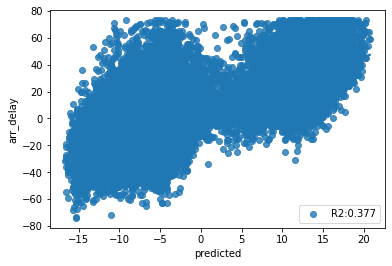

In [22]:
# Print the R2 score for the test dataset
print('R2 Score for train data:', round(rf.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'arr_delay':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='arr_delay',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

#### DRAFT

#### Random Forest Grid Search

In [ ]:
# Define hyperparameters we want to tune
param_grid = {
    'n_estimators' : [10, 20, 100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [5,8,10,12,15]
}

# Instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)

In [ ]:
display(model.best_params_)
display(model.best_score_)

df.sort_values('rank_test_score', ascending = True).head(3)